<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#문제-정의-및-가설-설정" data-toc-modified-id="문제-정의-및-가설-설정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>문제 정의 및 가설 설정</a></span><ul class="toc-item"><li><span><a href="#요청-사항" data-toc-modified-id="요청-사항-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>요청 사항</a></span></li><li><span><a href="#문제-정의" data-toc-modified-id="문제-정의-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>문제 정의</a></span></li><li><span><a href="#가설-수립-및-예상-Output" data-toc-modified-id="가설-수립-및-예상-Output-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>가설 수립 및 예상 Output</a></span></li></ul></li><li><span><a href="#Data-Load" data-toc-modified-id="Data-Load-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Load</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#날짜-datetime-형태로-변환" data-toc-modified-id="날짜-datetime-형태로-변환-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>날짜 datetime 형태로 변환</a></span></li><li><span><a href="#Missing-value-확인" data-toc-modified-id="Missing-value-확인-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Missing value 확인</a></span></li><li><span><a href="#결측치-처리" data-toc-modified-id="결측치-처리-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>결측치 처리</a></span><ul class="toc-item"><li><span><a href="#결측치가-수치형-변수인-경우" data-toc-modified-id="결측치가-수치형-변수인-경우-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>결측치가 수치형 변수인 경우</a></span></li><li><span><a href="#결측치가-카테고리-변수인-경우" data-toc-modified-id="결측치가-카테고리-변수인-경우-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>결측치가 카테고리 변수인 경우</a></span></li></ul></li><li><span><a href="#확장자명-통일" data-toc-modified-id="확장자명-통일-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>확장자명 통일</a></span></li><li><span><a href="#action-type-통일" data-toc-modified-id="action-type-통일-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>action type 통일</a></span></li><li><span><a href="#신규-session_id-부여" data-toc-modified-id="신규-session_id-부여-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>신규 session_id 부여</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#일별-Trend---log,-session" data-toc-modified-id="일별-Trend---log,-session-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>일별 Trend - log, session</a></span></li><li><span><a href="#일별-Trend---확장자,-위치,-액션,-스크린" data-toc-modified-id="일별-Trend---확장자,-위치,-액션,-스크린-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>일별 Trend - 확장자, 위치, 액션, 스크린</a></span></li><li><span><a href="#Pivoting을-통한-별수별-특성-탐색" data-toc-modified-id="Pivoting을-통한-별수별-특성-탐색-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Pivoting을 통한 별수별 특성 탐색</a></span></li><li><span><a href="#변수별-분포-및-상관관계" data-toc-modified-id="변수별-분포-및-상관관계-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>변수별 분포 및 상관관계</a></span></li><li><span><a href="#구간별-전환율-(Funnel)" data-toc-modified-id="구간별-전환율-(Funnel)-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>구간별 전환율 (Funnel)</a></span><ul class="toc-item"><li><span><a href="#3.5-중간-정리" data-toc-modified-id="3.5-중간-정리-4.5.1"><span class="toc-item-num">4.5.1&nbsp;&nbsp;</span>3.5 중간 정리</a></span></li></ul></li></ul></li><li><span><a href="#Clustering-for-Targeting" data-toc-modified-id="Clustering-for-Targeting-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Clustering for Targeting</a></span><ul class="toc-item"><li><span><a href="#Kmeans" data-toc-modified-id="Kmeans-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Kmeans</a></span></li><li><span><a href="#Conversion-rate-by-cluster" data-toc-modified-id="Conversion-rate-by-cluster-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Conversion rate by cluster</a></span></li></ul></li></ul></div>

- [Python 데이터 분석 실무](https://wikidocs.net/book/1867) 의 예제 실습
- [실습 데이터 및 코드](https://github.com/songhunhwa/songhunhwa.github.com/tree/master/tutorial/tutorial_02) songhunhwa(저자)님의 github

# 문제 정의 및 가설 설정

## 요청 사항

기획부서의 요청 내용
- 새로운 시나리오를 유저가 잘 사용하고 있는지 알려주세요
- 잘 사용되고 있는 기능은 무엇인가요?
- 개선을 어떻게 해야할지 알려주세요  

----
해석     
→ 기획부서에서 만든 새로운 시나리오 대로 유저가 앱을 잘 사용하고 있는지       
→ 만약 그렇다면 어떤 기능이 잘 사용되는지       
→ 이탈이 많다면 어느 구간인지, 어떻게 그 구간을 개선할지     

## 문제 정의
- Funnel 방식으로 유저의 행동 패턴을 파악하여, 해당 시나리오의 Bottleneck 구간을 탐색
- 유저를 세분화하여 Bottleneck 개선 방안에 유용한 insight를 도출

## 가설 수립 및 예상 Output
- 가설을 만들고 예상 output을 그려보는 과정은 데이터 수집/분석 과정에서 도움이 되기도 함
    - but, 가설 설정을 상황에 따라 생략할 수 있는 부분이며, 오히려 데이터의 탐색 범위를 좁히는 결과를 낳을 수도 있음
    - 목적 설정 과정에 비해 중요도가 높지 않음

가설   
1. 이탈이 많이 발생하는 구간은 **'구매 상세 페이지'에서 '구매 완료'로 전환하는 구간**일 것이다. (Bottleneck)
    - 이유 - 구매는 돈을 지불해야하는 행위 → 일반적으로 목적 달성이 어려움
2. 그룹 조건에 따라 전환율이나 이탈율에서 통계적으로 유의미한 차이를 보일 것이다.
    - 이유 - 그룹 조건은 행동 패턴을 결정짓는 주요 요인 중 하나이므로, 위와같은 결과가 나올 것
    - 단, 그룹 세분화가 진행되기 전이므로 다소 오픈 결론으로 유지

# Data Load
- 문서 앱내 사용시 발생하는 로그 데이터
- 서버로그와 달리, 유저의 행동이 발생할 경우 로그 수집 (유저 행동 패턴 파악에 용이)
    - 클라이언트(앱) 로그
    - 서버 로그
- Columns Info.
    - actiontype: 문서 이용시 행동(open, close, save, ..)
    - ismydoc: 내문서 해당 여부(중요X)
    - ext: 문서 확장자
    - sessionid: 유저 식별자
    - documentposition: 문서 이용시 위치 정보(cloud, otherapp)
    - datetime: Timestamp
    - screen: 앱내 화면 이름

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-paper')

In [2]:
df = pd.read_csv('df_funnel.csv', index_col=0)
df

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016.7.18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016.7.18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016.7.18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016.7.18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016.7.6,Main
...,...,...,...,...,...,...,...
301856,CLOSE,View,XLSX,2ed068d5e6a72e80e4a997c01c59f782,OTHERAPP,2016.7.7,Main
301857,OPEN,NoView,DOCX,41b8c1df291edd2aec30fc610e5b676e,OTHERAPP,2016.7.5,Main
301858,RESET,View,DOCX,41b8c1df291edd2aec30fc610e5b676e,OTHERAPP,2016.7.5,Main
301859,OPEN,NoView,PPT,9b5ee236571c2fcbe25132b6ba71d764,OTHERAPP,2016.7.14,Main


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301861 entries, 0 to 301860
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   actiontype        301861 non-null  object
 1   ismydoc           301861 non-null  object
 2   ext               301861 non-null  object
 3   sessionid         301861 non-null  object
 4   documentposition  301861 non-null  object
 5   datetime          301861 non-null  object
 6   screen            301861 non-null  object
dtypes: object(7)
memory usage: 18.4+ MB


# Preprocessing
- type 변환
- 결측치 처리
- 신규 session id 부여
- 대소문자 처리

## 날짜 datetime 형태로 변환

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main


## Missing value 확인

In [5]:
df.isnull().sum()

actiontype          0
ismydoc             0
ext                 0
sessionid           0
documentposition    0
datetime            0
screen              0
dtype: int64

## 결측치 처리

### 결측치가 수치형 변수인 경우

In [6]:
df_by_screen = df.groupby(['datetime','screen'])['sessionid'].nunique().unstack()
df_by_screen[:10]

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-01,137.0,147.0,3582.0,296.0,1008.0,2.0,23.0
2016-07-02,89.0,124.0,2683.0,206.0,801.0,2.0,15.0
2016-07-03,50.0,83.0,1886.0,165.0,590.0,NaN,28.0
2016-07-04,112.0,104.0,2808.0,281.0,764.0,NaN,29.0
2016-07-05,118.0,138.0,3335.0,300.0,842.0,1.0,26.0
2016-07-06,138.0,145.0,3256.0,293.0,855.0,1.0,30.0
2016-07-07,110.0,117.0,3150.0,266.0,807.0,NaN,18.0
2016-07-08,117.0,148.0,3208.0,273.0,865.0,2.0,20.0
2016-07-09,102.0,138.0,2381.0,229.0,748.0,2.0,23.0


In [7]:
df_by_screen.isnull().sum()

screen
InProduct_Mob    0
InProduct_Web    0
Main             0
Per_Dir          0
Pub_Dir          0
Purchase_done    6
Purchase_page    0
dtype: int64

In [8]:
df_by_screen.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2016-07-01 to 2016-07-30
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   InProduct_Mob  30 non-null     float64
 1   InProduct_Web  30 non-null     float64
 2   Main           30 non-null     float64
 3   Per_Dir        30 non-null     float64
 4   Pub_Dir        30 non-null     float64
 5   Purchase_done  24 non-null     float64
 6   Purchase_page  30 non-null     float64
dtypes: float64(7)
memory usage: 1.9 KB


In [9]:
# 비즈니스 맥락 및 목적(퍼널분석) 고려 시, 해당 결측치 0으로 처리하는 것이 알맞다 판단됨
df_by_screen.fillna(0, inplace=True)
df_by_screen[:10]

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-01,137.0,147.0,3582.0,296.0,1008.0,2.0,23.0
2016-07-02,89.0,124.0,2683.0,206.0,801.0,2.0,15.0
2016-07-03,50.0,83.0,1886.0,165.0,590.0,0.0,28.0
2016-07-04,112.0,104.0,2808.0,281.0,764.0,0.0,29.0
2016-07-05,118.0,138.0,3335.0,300.0,842.0,1.0,26.0
2016-07-06,138.0,145.0,3256.0,293.0,855.0,1.0,30.0
2016-07-07,110.0,117.0,3150.0,266.0,807.0,0.0,18.0
2016-07-08,117.0,148.0,3208.0,273.0,865.0,2.0,20.0
2016-07-09,102.0,138.0,2381.0,229.0,748.0,2.0,23.0


### 결측치가 카테고리 변수인 경우
- Option 1. 최빈치(mode)
    - 쉽고 빠르게 이용가능하나, 낮은 적절성
- Option 2. 예측모형으로 예측치
    - 적절성은 비교적 높으나 별도의 모형과 계산량 필요

In [10]:
# 여기는 카테고리형 변수에 결측치 없으므로 생략

## 확장자명 통일

In [11]:
df['ext'].value_counts()

PDF      82004
DOCX     58303
XLSX     52118
HWP      26244
DOC      24586
XLS      24489
PPTX     15385
TXT       9814
PPT       5382
PPSX      2374
ODT        820
PPS        324
JPG          9
SHEET        5
WORD         2
PNG          2
Name: ext, dtype: int64

In [12]:
ext_dic = {
    'DOCX':'DOC',
    'XLSX':'XLS',
    'PPTX':'PPT',
    'PPSX':'PPT',
    'PPS':'PPT',
    'ODT':'TXT',
    'PNG':'JPG'
}

In [13]:
df['ext'] = df['ext'].replace(ext_dic)
df['ext'].value_counts()

DOC      82889
PDF      82004
XLS      76607
HWP      26244
PPT      23465
TXT      10634
JPG         11
SHEET        5
WORD         2
Name: ext, dtype: int64

## action type 통일

In [14]:
df.actiontype.value_counts()

OPEN            151802
CLOSE           127922
SAVE              9334
RESET             7751
SAVEAS            4960
EXPORT_SAME         68
EXPORT              19
SAVEAS_OTHER         5
Name: actiontype, dtype: int64

In [15]:
act_dic = {'SAVEAS':'SAVE',
          'SAVEAS_OTHER':'SAVE',
          'EXPORT_SAME':'EXPORT'}

In [16]:
df['actiontype'].replace(act_dic, inplace=True)
df['actiontype'].value_counts()

OPEN      151802
CLOSE     127922
SAVE       14299
RESET       7751
EXPORT        87
Name: actiontype, dtype: int64

## 신규 session_id 부여
- 필수는 아니지만, 계산량 감소를 위해 텍스트 사이즈 감량 진행
- session0, 1, ...

In [17]:
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main


In [18]:
# session + unique number
session_num = []
n = 0

# session 번호 - 같은, 다른
for i in range(len(df)-1):
    # compare each rows
    if df.loc[i, 'sessionid'] == df.loc[i+1, 'sessionid']:
        session_num.append(n)
    else:
        session_num.append(n)
        n += 1

In [19]:
session_num[:10]

[0, 0, 0, 0, 1, 1, 2, 2, 3, 3]

In [20]:
df['sessionid'] = pd.Series(['session' + str(num) for num in session_num ])
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,session0,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,session0,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,session0,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,session0,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,session1,OTHERAPP,2016-07-06,Main


In [21]:
df.tail()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
301856,CLOSE,View,XLS,session132151,OTHERAPP,2016-07-07,Main
301857,OPEN,NoView,DOC,session132152,OTHERAPP,2016-07-05,Main
301858,RESET,View,DOC,session132152,OTHERAPP,2016-07-05,Main
301859,OPEN,NoView,PPT,session132153,OTHERAPP,2016-07-14,Main
301860,CLOSE,NoView,PPT,NaN,OTHERAPP,2016-07-14,Main


In [22]:
# 이전 row의 session과 동일 session이었음
df.loc[301860, 'sessionid'] = 'session132153'

In [23]:
df.tail()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
301856,CLOSE,View,XLS,session132151,OTHERAPP,2016-07-07,Main
301857,OPEN,NoView,DOC,session132152,OTHERAPP,2016-07-05,Main
301858,RESET,View,DOC,session132152,OTHERAPP,2016-07-05,Main
301859,OPEN,NoView,PPT,session132153,OTHERAPP,2016-07-14,Main
301860,CLOSE,NoView,PPT,session132153,OTHERAPP,2016-07-14,Main


# EDA
- 일별 주요 통계
- 변수별 특성
- 구간별 전환율(Funnel Analysis)
- 클러스터링
- 클러스터별 전환율 차이 파악

## 일별 Trend - log, session
- 일별 로그 카운트
- 일별 세션 카운트
- 요일별 세션 카운트

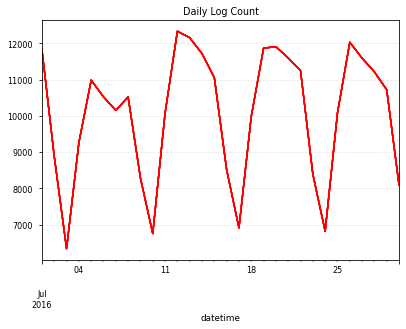

In [24]:
# daily log size
df.groupby('datetime').count().plot(c='r', legend=False)
plt.title('Daily Log Count')
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.show()

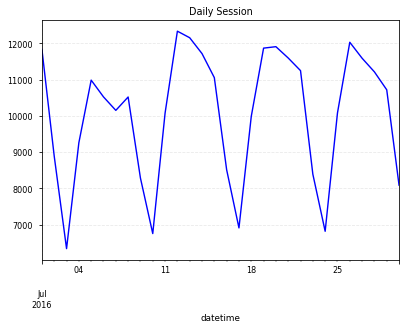

In [25]:
# daily session count (active 유저의 session)
df.groupby('datetime')['sessionid'].count().plot(c='b', legend=False)

plt.title('Daily Session')
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.show()

- 앱 사용에 seasonality 존재
- 로그 수와 세션 수의 트렌드가 유사

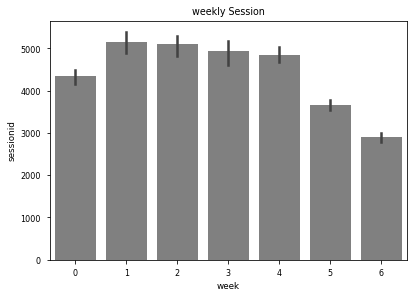

In [26]:
# weekly session count
# 0: Mon ~ 6: Sun
tmp = df.groupby('datetime')[['sessionid']].nunique().reset_index()
tmp['week'] = tmp['datetime'].apply(lambda x: x.weekday())

sns.barplot(data=tmp, x='week', y='sessionid', color='grey')
plt.title('weekly Session')
# plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.show()

- 주말에 사용성이 감소하고, 평일에 높은 편
    - 화, 수요일에 가장 많이 사용하고, 월요일은 평일대비 비교적 낮은편
- 문서앱 특성상 직장인 or 학생이 주로 사용하는 것을 고려하면 당연한 결과

## 일별 Trend - 확장자, 위치, 액션, 스크린

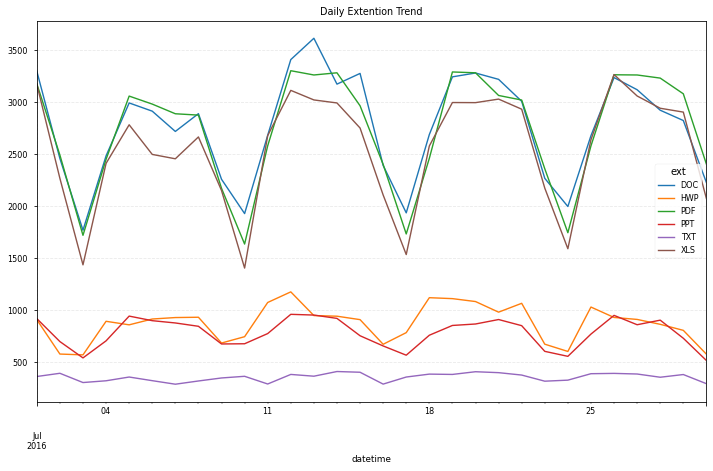

In [27]:
# daily trend by extention(ext)
df.groupby(["datetime", "ext"]).size().unstack().dropna(axis=1).plot(figsize=(12,7))

plt.title("Daily Extention Trend")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.show()

- doc, pdf, xls 순으로 주로 사용 (1 tier)
- 2 tier hwp, ppt

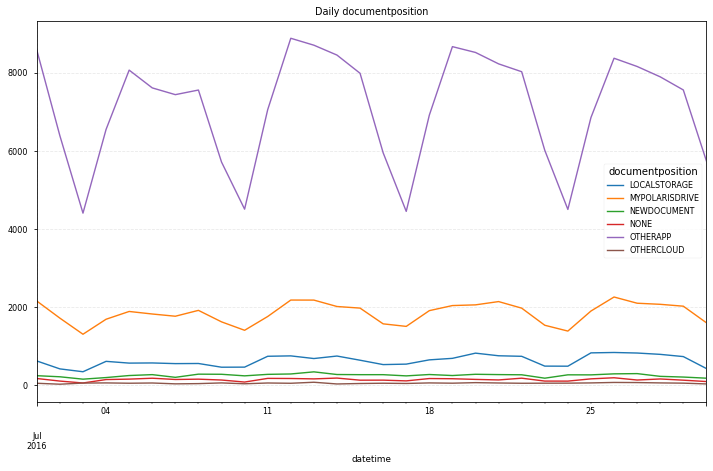

In [28]:
# daily trend by position
df.groupby(["datetime", "documentposition"]).size().unstack().dropna(axis=1).plot(figsize=(12,7))

plt.title("Daily documentposition")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.show()

- 주요 문서 이용 위치는 otherapp

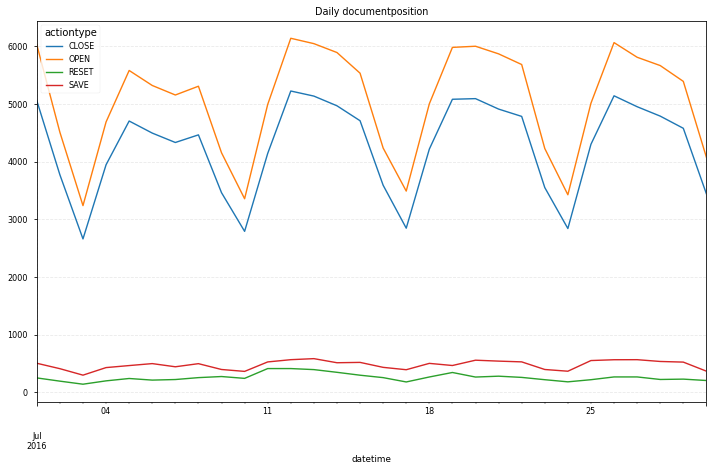

In [29]:
# daily trend by action
df.groupby(["datetime", "actiontype"]).size().unstack().dropna(axis=1).plot(figsize=(12,7))

plt.title("Daily documentposition")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.show()

- open, close action이 가장 많음

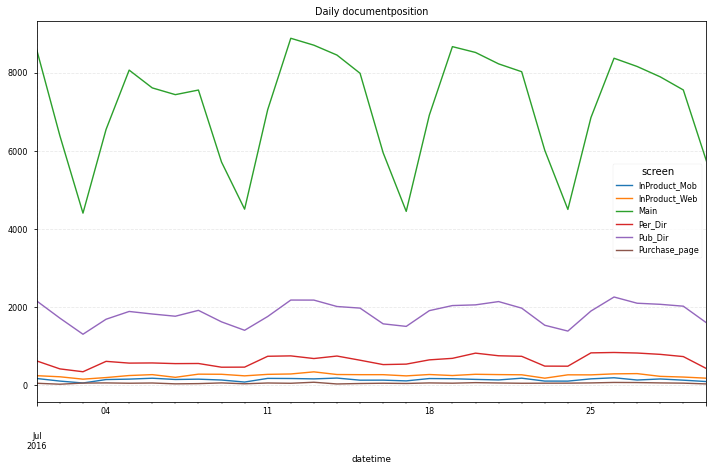

In [30]:
# daily trend by screen name
df.groupby(["datetime", "screen"]).size().unstack().dropna(axis=1).plot(figsize=(12,7))

plt.title("Daily documentposition")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.show()

In [31]:
# heat map
screens = df.groupby(['datetime', 'screen'])['sessionid'].nunique().unstack().fillna(0).astype(int)

# cols order change
screens = screens[screens.mean().sort_values(ascending=False).index]

screens[:10]

screen,Main,Pub_Dir,Per_Dir,InProduct_Web,InProduct_Mob,Purchase_page,Purchase_done
datetime,,,,,,,
2016-07-01,3911,1112,381,178,143,24,2
2016-07-02,2935,888,251,140,92,15,2
2016-07-03,2005,648,197,85,50,33,0
2016-07-04,3016,847,349,120,124,32,0
2016-07-05,3631,942,354,159,127,28,1
2016-07-06,3525,949,374,163,148,31,1
2016-07-07,3433,896,324,133,127,18,0
2016-07-08,3477,961,339,169,127,23,2
2016-07-09,2605,865,277,178,110,30,2


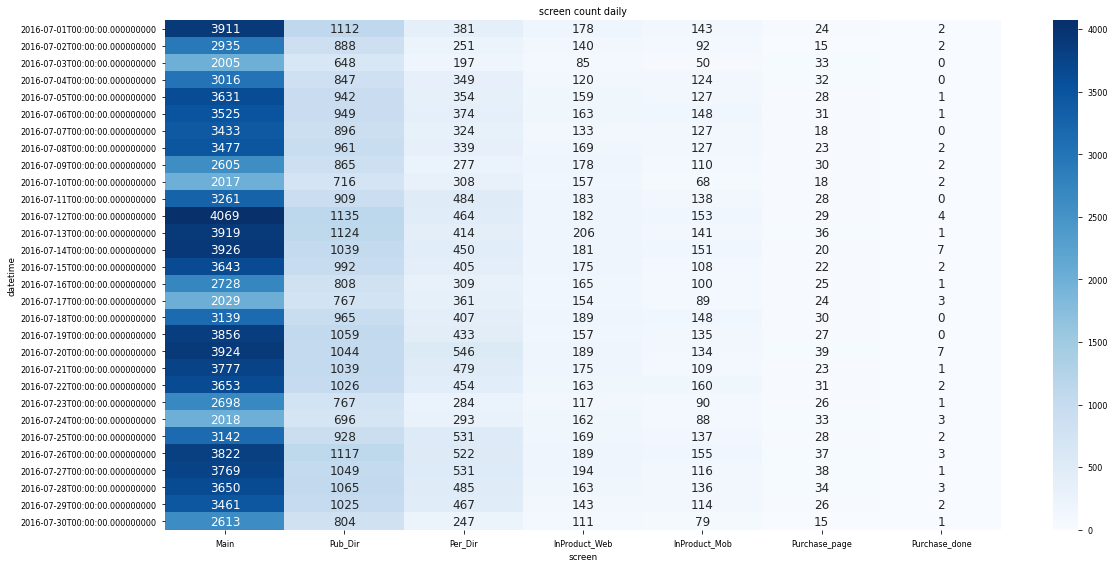

In [32]:
plt.subplots(figsize=(17,8))

sns.heatmap(screens, annot=True, fmt="d", annot_kws={"size": 12}, cmap='Blues');

plt.title("screen count daily")
plt.tight_layout()

- main -> purchase_done까지 과정에서 대부분 이탈함

## Pivoting을 통한 별수별 특성 탐색

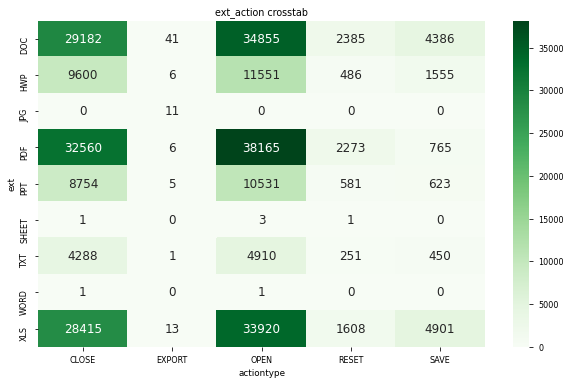

In [35]:
plt.subplots(figsize=(10,6))

ext_action = df.groupby(['ext','actiontype'])['sessionid'].nunique().unstack().fillna(0).astype(int)
sns.heatmap(ext_action, annot=True, fmt='d', annot_kws={'size':12}, cmap='Greens')

plt.title('ext_action crosstab')
plt.show()

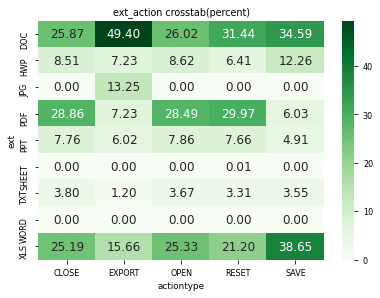

In [42]:
# count to percent
ext_action_percent = df.groupby(['ext', 'actiontype'])['sessionid'].nunique().unstack().fillna(0).apply(lambda x: x/x.sum()*100).round(2)
sns.heatmap(ext_action_percent, annot=True, fmt='.2f',annot_kws={'size':12}, cmap='Greens')

plt.title('ext_action crosstab(percent)')
plt.show()

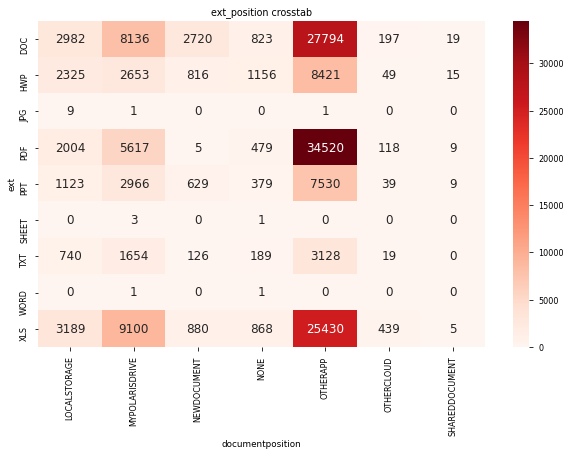

In [44]:
plt.subplots(figsize=(10,6))

ext_pos = df.groupby(['ext','documentposition'])['sessionid'].nunique().unstack().fillna(0).astype(int)
sns.heatmap(ext_pos, annot=True, fmt='d', annot_kws={'size':12}, cmap='Reds')

plt.title('ext_position crosstab')
plt.show()

## 변수별 분포 및 상관관계
- open 기준

In [48]:
ext_by_session = df.query("actiontype=='OPEN'").groupby(['sessionid', 'ext']).size().unstack().dropna(how='all')
ext_by_session

ext,DOC,HWP,PDF,PPT,SHEET,TXT,WORD,XLS
sessionid,,,,,,,,
session0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
session1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
session10,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
session100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
session1000,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
session99995,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
session99996,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
session99997,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
pos_by_session = df.query("actiontype=='OPEN'").groupby(['sessionid', 'documentposition']).size().unstack().dropna(how='all')
pos_by_session

documentposition,LOCALSTORAGE,MYPOLARISDRIVE,NEWDOCUMENT,OTHERAPP,OTHERCLOUD,SHAREDDOCUMENT
sessionid,,,,,,
session0,1.0,1.0,NaN,NaN,NaN,NaN
session1,NaN,NaN,NaN,1.0,NaN,NaN
session10,NaN,1.0,NaN,1.0,NaN,NaN
session100,NaN,NaN,NaN,1.0,NaN,NaN
session1000,NaN,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...
session99995,NaN,NaN,NaN,1.0,NaN,NaN
session99996,NaN,1.0,NaN,2.0,NaN,NaN
session99997,NaN,NaN,NaN,1.0,NaN,NaN


In [54]:
# join - sessionid key
ext_pos = pd.concat([ext_by_session, pos_by_session], axis=1).fillna(0)
ext_pos

,DOC,HWP,PDF,PPT,SHEET,TXT,WORD,XLS,LOCALSTORAGE,MYPOLARISDRIVE,NEWDOCUMENT,OTHERAPP,OTHERCLOUD,SHAREDDOCUMENT
sessionid,,,,,,,,,,,,,,
session0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
session1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
session10,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
session100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
session1000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
session99995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
session99996,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
session99997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [55]:
ext_pos.describe().round(2)

,DOC,HWP,PDF,PPT,SHEET,TXT,WORD,XLS,LOCALSTORAGE,MYPOLARISDRIVE,NEWDOCUMENT,OTHERAPP,OTHERCLOUD,SHAREDDOCUMENT
count,120657.00,120657.00,120657.00,120657.00,120657.0,120657.00,120657.0,120657.00,120657.00,120657.00,120657.00,120657.00,120657.00,120657.00
mean,0.34,0.11,0.35,0.10,0.0,0.04,0.0,0.31,0.07,0.21,0.04,0.93,0.01,0.00
std,0.59,0.35,0.55,0.35,0.0,0.21,0.0,0.54,0.27,0.47,0.20,0.69,0.08,0.02
min,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,1.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,1.00,0.00,0.00
75%,1.00,0.00,1.00,0.00,0.0,0.00,0.0,1.00,0.00,0.00,0.00,1.00,0.00,0.00
max,6.00,6.00,4.00,5.00,1.0,4.00,1.0,7.00,5.00,7.00,4.00,9.00,4.00,2.00


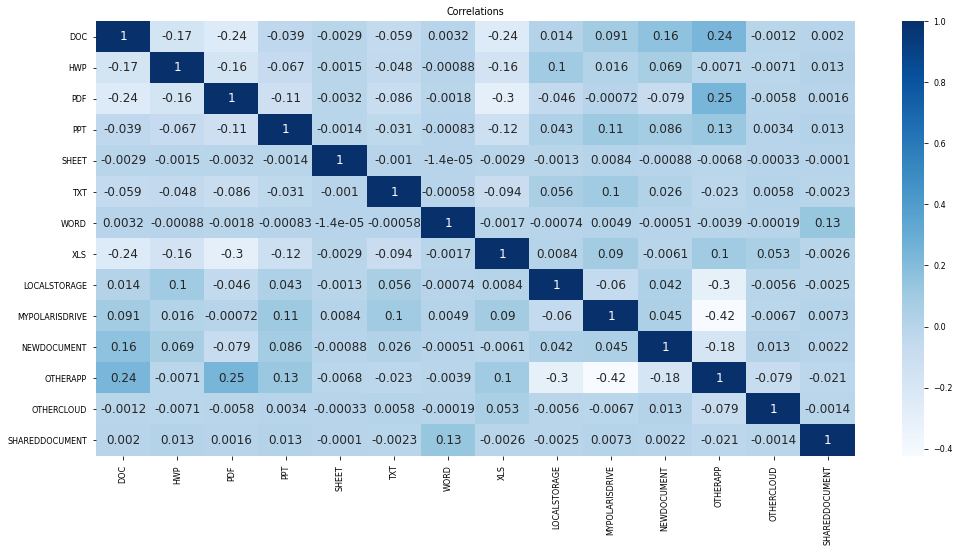

In [58]:
plt.subplots(figsize=(17,8))

sns.heatmap(ext_pos.corr(), annot=True, annot_kws={'size': 12}, cmap='Blues')

plt.title('Correlations')
plt.show()

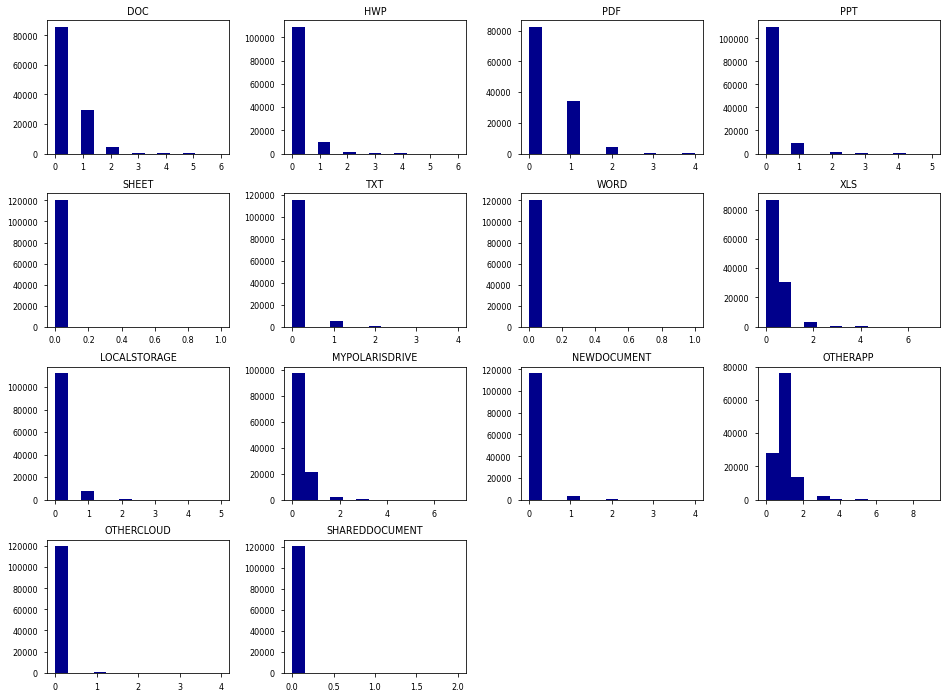

In [63]:
ext_pos.hist(bins=13,color='darkblue', figsize=(16,12), grid=False)

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.show()

## 구간별 전환율 (Funnel)

In [64]:
screens.head(10)

screen,Main,Pub_Dir,Per_Dir,InProduct_Web,InProduct_Mob,Purchase_page,Purchase_done
datetime,,,,,,,
2016-07-01,3911,1112,381,178,143,24,2
2016-07-02,2935,888,251,140,92,15,2
2016-07-03,2005,648,197,85,50,33,0
2016-07-04,3016,847,349,120,124,32,0
2016-07-05,3631,942,354,159,127,28,1
2016-07-06,3525,949,374,163,148,31,1
2016-07-07,3433,896,324,133,127,18,0
2016-07-08,3477,961,339,169,127,23,2
2016-07-09,2605,865,277,178,110,30,2


In [65]:
# mean of each days
conver_mean_cnt = screens.mean().apply(lambda x: int(x)).sort_values(ascending=False)
conver_mean_cnt

screen
Main             3255
Pub_Dir           939
Per_Dir           390
InProduct_Web     161
InProduct_Mob     119
Purchase_page      27
Purchase_done       1
dtype: int64

In [66]:
# average conversion rate
conver_rt = []
for i in range(len(conver_mean_cnt)-1):
    conver_rt.append((conver_mean_cnt[i+1] / (conver_mean_cnt[i]) * 100).round(2))

conver_rt

[28.85, 41.53, 41.28, 73.91, 22.69, 3.7]

In [71]:
# create labels
funnel_label = [conver_mean_cnt.index[k] + ' > ' + conver_mean_cnt.index[k+1] for k, v in enumerate(conver_mean_cnt.index) if k < 6]
funnel_label

['Main > Pub_Dir',
 'Pub_Dir > Per_Dir',
 'Per_Dir > InProduct_Web',
 'InProduct_Web > InProduct_Mob',
 'InProduct_Mob > Purchase_page',
 'Purchase_page > Purchase_done']

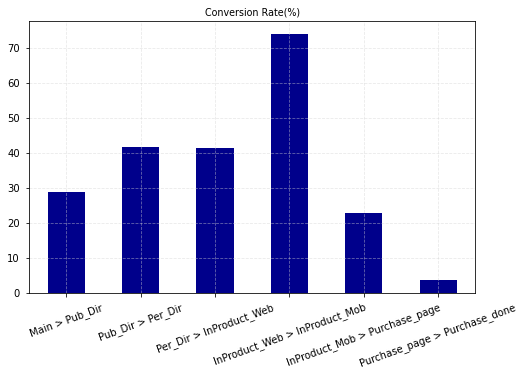

In [72]:
pd.Series(conver_rt, index=funnel_label).plot(kind='bar', color='darkblue', rot=20, figsize=(8,5), fontsize=10)

plt.title('Conversion Rate(%)')
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.show()

- 웹에서 앱으로 넘어가는 전환율이 가장 높음
- 구매 페이지에서 구매 완료로 가는 전환율이 가장 낮음

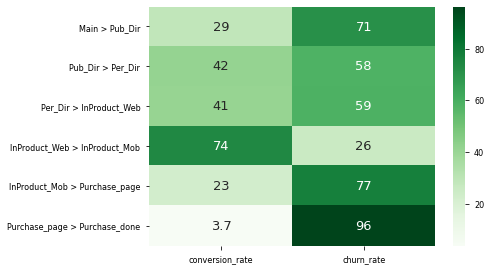

In [76]:
# conversion, churn
conv_rt_tb = pd.Series(conver_rt, index=funnel_label).to_frame()
conv_rt_tb.index_name = 'Funnel'
conv_rt_tb.columns=['conversion_rate']
conv_rt_tb['churn_rate'] = 100 - conv_rt_tb['conversion_rate']

sns.heatmap(conv_rt_tb, annot=True, annot_kws={'size':13}, cmap='Greens')
plt.show()

### 3.5 중간 정리
- **일별 주요 통계**
    - 활성화 세션의 경우 주말에 감소하고 주중에 증가하는 트렌드 보임
    - 확장자별 1 tier에는 pdf, xls, doc가 포지셔닝되며, 2 tier에는 hwp, ppt가 포함됨
    - 문서의 이용 위치는 'other app' 이 압도적으로 높음
    - 스크린별로 사용성 파악 결과, 메인(main) 화면이 가장 많이 노출되며 다음 화면(pub_dir or per_dir)으로 넘어가는 경우 많지 않음

- **구간별 전환율**
    - 전환율이 가장 낮은 구간(=이탈이 가장 높은 구간)은 구매정보 페이지에서 구매 완료 페이지로 전환하는 구간임(3.7%)
    - 제품내 웹 -> 앱으로 전환하는 구간은 전환율이 양호함(74%)

# Clustering for Targeting

## Kmeans

In [77]:
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,session0,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,session0,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,session0,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,session0,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,session1,OTHERAPP,2016-07-06,Main


In [90]:
# 확장자 변수 기준으로만 진행
# if, 다른 변수도 같이 있었으면 scaling 필요
df_ext = df.query("actiontype == 'OPEN'").groupby(["sessionid", "ext"]).size().unstack().fillna(0)
df_ext

ext,DOC,HWP,PDF,PPT,SHEET,TXT,WORD,XLS
sessionid,,,,,,,,
session0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
session1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
session10,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
session100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
session1000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
session99995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
session99996,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
session99997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
df_ext_elbow = df_ext.copy()

In [92]:
from sklearn.cluster import KMeans

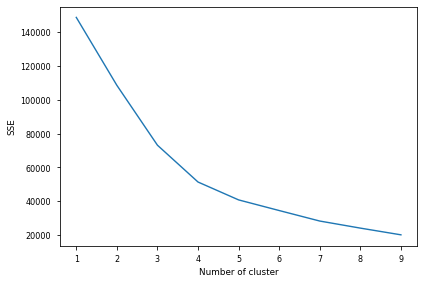

In [93]:
# elbow
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_ext_elbow)
    df_ext_elbow['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.ylabel('SSE')
plt.show()

- k=4

In [95]:
km = KMeans(n_clusters=4).fit(df_ext)

In [97]:
labels = km.labels_
labels

array([3, 3, 1, ..., 2, 0, 3])

In [98]:
df_ext['group'] = labels
df_ext.head()

ext,DOC,HWP,PDF,PPT,SHEET,TXT,WORD,XLS,group
sessionid,,,,,,,,,
session0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3
session1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3
session10,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1
session100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
session1000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3


In [100]:
df_ext.group.value_counts()

3    34870
2    32514
0    31736
1    21537
Name: group, dtype: int64

In [101]:
df_ext_mean = df_ext.groupby('group').mean().round(2)
df_ext_mean

ext,DOC,HWP,PDF,PPT,SHEET,TXT,WORD,XLS
group,,,,,,,,
0,0.06,0.01,0.01,0.02,0.0,0.01,0.0,1.12
1,0.00,0.57,0.01,0.39,0.0,0.19,0.0,0.00
2,1.18,0.00,0.10,0.06,0.0,0.02,0.0,0.02
3,0.01,0.01,1.12,0.03,0.0,0.01,0.0,0.04


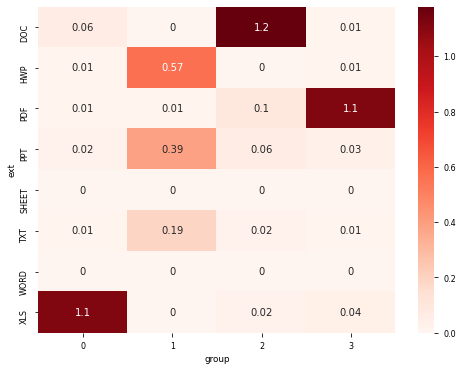

In [102]:
plt.subplots(figsize=(8,6))

sns.heatmap(df_ext_mean.T, annot=True, cmap='Reds')

plt.show()

In [103]:
# labeling (군집 실행시마다 번호 바뀌니 주의)
group_name = {0:'gr_xls',
             1:'gr_hwp',   #ppt
             2:'gr_doc',
             3:'gr_pdf'}

In [105]:
df_ext['group'] = df_ext['group'].replace(group_name)
df_ext.head()

ext,DOC,HWP,PDF,PPT,SHEET,TXT,WORD,XLS,group
sessionid,,,,,,,,,
session0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,gr_pdf
session1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,gr_pdf
session10,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,gr_hwp
session100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,gr_xls
session1000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,gr_pdf


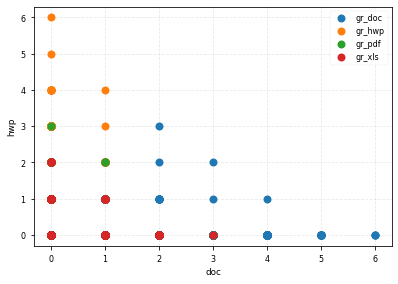

In [106]:
groups = df_ext.groupby("group")

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group['DOC'], group['HWP'], marker='o', linestyle='', ms=8, label=name)
    ax.legend()

plt.xlabel("doc")
plt.ylabel("hwp")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.show()

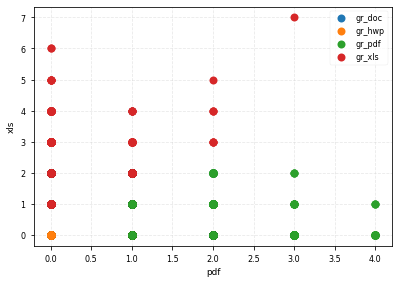

In [107]:
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group['PDF'], group['XLS'], marker='o', linestyle='', ms=8, label=name)
    ax.legend()

plt.xlabel("pdf")
plt.ylabel("xls")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.show()

## Conversion rate by cluster

In [108]:
df_open = df.query("actiontype=='OPEN'")
df_open.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,session0,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,session0,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,session1,OTHERAPP,2016-07-06,Main
7,OPEN,NoView,PDF,session2,OTHERAPP,2016-07-20,Main
8,OPEN,NoView,PDF,session3,OTHERAPP,2016-07-28,Main


In [111]:
df_open.shape

(151802, 7)

In [110]:
# join
df_cluster = pd.merge(df_open, df_ext[['group']], on='sessionid', how='left')
df_cluster

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen,group
0,OPEN,NoView,PDF,session0,LOCALSTORAGE,2016-07-18,Per_Dir,gr_pdf
1,OPEN,View,PDF,session0,MYPOLARISDRIVE,2016-07-18,Pub_Dir,gr_pdf
2,OPEN,NoView,PDF,session1,OTHERAPP,2016-07-06,Main,gr_pdf
3,OPEN,NoView,PDF,session2,OTHERAPP,2016-07-20,Main,gr_pdf
4,OPEN,NoView,PDF,session3,OTHERAPP,2016-07-28,Main,gr_pdf
...,...,...,...,...,...,...,...,...
151797,OPEN,View,XLS,session132149,OTHERAPP,2016-07-08,Main,gr_xls
151798,OPEN,View,XLS,session132150,OTHERAPP,2016-07-18,Main,gr_xls
151799,OPEN,View,XLS,session132151,OTHERAPP,2016-07-07,Main,gr_xls
151800,OPEN,NoView,DOC,session132152,OTHERAPP,2016-07-05,Main,gr_doc


In [118]:
# group별 conversion rate 계산 함수
def conv_rt_by_group(gr):
    df_gr_screen = df_cluster[df_cluster['group'] == gr]\
                    .groupby(['datetime', 'screen'])['sessionid']\
                    .nunique().unstack().fillna(0).astype(int)
    
    conver_mean_cnt = df_gr_screen.mean().apply(lambda x: int(x)).sort_values(ascending=False)
    conver_rt = [conver_mean_cnt[i+1] / conver_mean_cnt[i] * 100 for i in range(len(conver_mean_cnt)) if i <5]
    funnel_label = [conver_mean_cnt.index[k] + ' > ' + conver_mean_cnt.index[k+1] for k, v in enumerate(conver_mean_cnt.index) if k < 5]
    conver_rt = pd.Series(conver_rt, index=funnel_label).fillna(0)
    
    return conver_rt

In [119]:
conv_rt_pdf = conv_rt_by_group('gr_pdf')
conv_rt_pdf

Main > Pub_Dir                   15.369458
Pub_Dir > Per_Dir                29.487179
Per_Dir > InProduct_Web           6.521739
InProduct_Web > Purchase_page    66.666667
Purchase_page > Purchase_done     0.000000
dtype: float64

In [120]:
conv_rt_doc = conv_rt_by_group('gr_doc')
conv_rt_doc

Main > Pub_Dir                   24.791418
Pub_Dir > InProduct_Web          34.134615
InProduct_Web > Per_Dir          90.140845
Per_Dir > Purchase_page           4.687500
Purchase_page > Purchase_done     0.000000
dtype: float64

In [121]:
conv_rt_xls = conv_rt_by_group('gr_xls')
conv_rt_xls

Main > Pub_Dir                   33.377660
Pub_Dir > Per_Dir                27.490040
Per_Dir > InProduct_Web          34.782609
InProduct_Web > Purchase_page    45.833333
Purchase_page > Purchase_done     0.000000
dtype: float64

In [122]:
conv_rt_hwp = conv_rt_by_group('gr_hwp')
conv_rt_hwp

Main > Pub_Dir                   32.024793
Pub_Dir > Per_Dir                55.483871
Per_Dir > InProduct_Web          37.209302
InProduct_Web > Purchase_page     6.250000
Purchase_page > Purchase_done     0.000000
dtype: float64

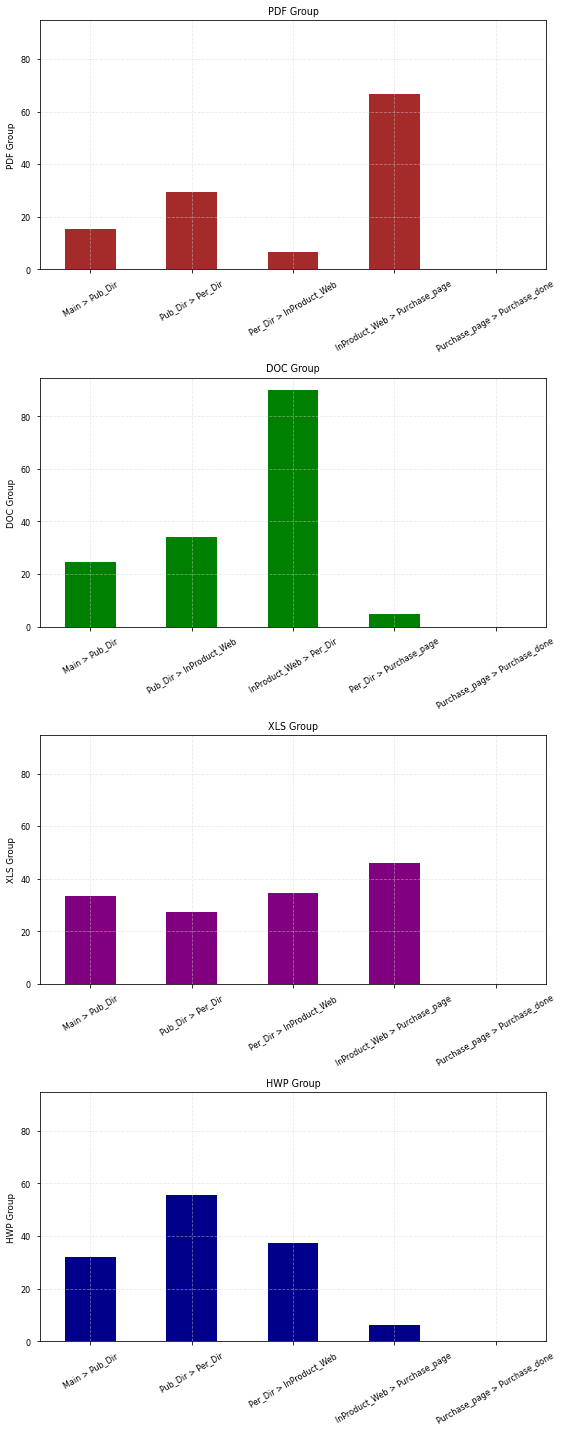

In [123]:
fig, ax = plt.subplots(4, 1, figsize=(8,20), sharey=True)

conv_rt_pdf.plot(kind='bar', ax=ax[0], color = 'brown', rot=30)
ax[0].set_title('PDF Group')
ax[0].set_ylabel('PDF Group')
ax[0].grid(color='lightgrey', alpha=0.5, linestyle='--')

conv_rt_doc.plot(kind='bar', ax=ax[1], color = 'green', rot=30)
ax[1].set_ylabel('DOC Group')
ax[1].set_title('DOC Group')
ax[1].grid(color='lightgrey', alpha=0.5, linestyle='--')

conv_rt_xls.plot(kind='bar', ax=ax[2], color = 'purple', rot=30)
ax[2].set_ylabel('XLS Group')
ax[2].set_title('XLS Group')
ax[2].grid(color='lightgrey', alpha=0.5, linestyle='--')

conv_rt_hwp.plot(kind='bar', ax=ax[3], color = 'darkblue', rot=30)
ax[3].set_ylabel('HWP Group')
ax[3].set_title('HWP Group')
ax[3].grid(color='lightgrey', alpha=0.5, linestyle='--')

plt.tight_layout()

In [124]:
# group별 평균 전환율

# 0 -> nan으로 변경 (평균 계산에 포함 X)
gr_pdf_avg = conv_rt_pdf.replace(0, np.nan).mean()
gr_doc_avg = conv_rt_doc.replace(0, np.nan).mean()
gr_xls_avg = conv_rt_xls.replace(0, np.nan).mean()
gr_hwp_avg = conv_rt_hwp.replace(0, np.nan).mean()

print('pdf', gr_pdf_avg)
print('doc', gr_doc_avg)
print('xls', gr_xls_avg)
print('hwp', gr_hwp_avg)

pdf 29.511260853089937
doc 38.43859470255567
xls 35.37091036102276
hwp 32.741991670438274


In [135]:
avg_df = pd.DataFrame({
        'group':['gr_pdf', 'gr_doc', 'gr_xls', 'gr_hwp'],
         'mean':[gr_pdf_avg,gr_doc_avg,gr_xls_avg,gr_hwp_avg],
})
avg_df.set_index('group', inplace=True)
avg_df

,mean
group,
gr_pdf,29.511261
gr_doc,38.438595
gr_xls,35.370910
gr_hwp,32.741992


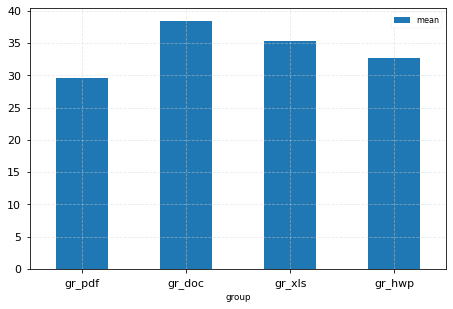

In [136]:
avg_df.plot(kind='bar', fontsize=11, rot=0)

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

- pdf group의 평균 전환률이 가장 낮음